In [1]:
# !pip install -qr "../requirements.txt"

In [1]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../')

# Load data

## Load data - Demonstration

In [2]:
df = pd.read_csv('../data/drive-me-not/trace1.csv')
# benign_flight.info()

#filter out the anchor points
df = df[df['Anchor_Number'] == 0]
df

,GPS_lat,GPS_long,Network_lat,Network_long,Time,Anchor_Number,Type,Registered,CID,LAC,MCC,MNC,dBm,level
0,25.328347,51.425060,0.0,0.0,1561278474631,0,GSM,True,23733,9301,427,1,-45,4
14,25.328347,51.425060,0.0,0.0,1561278474768,0,GSM,True,23733,9301,427,1,-45,4
28,25.328347,51.425060,0.0,0.0,1561278474932,0,GSM,True,23733,9301,427,1,-45,4
42,25.328347,51.425060,0.0,0.0,1561278475082,0,GSM,True,23733,9301,427,1,-45,4
56,25.328347,51.425060,0.0,0.0,1561278475263,0,GSM,True,23733,9301,427,1,-45,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34038,25.331563,51.421738,0.0,0.0,1561280145472,0,GSM,True,24882,9301,427,1,-57,4
34050,25.331563,51.421738,0.0,0.0,1561280155660,0,GSM,True,14792,150,427,2,-37,4
34057,25.331563,51.421738,0.0,0.0,1561280155829,0,GSM,True,24882,9301,427,1,-53,4
34070,25.331563,51.421738,0.0,0.0,1561280156156,0,GSM,True,24882,9301,427,1,-53,4


In [3]:
import pandasql as ps

# Filter out the rows whose change of position is not reflected in the coordinates
stmt = """SELECT * 
FROM df
WHERE Time in (
    SELECT min(Time) 
    FROM df
    GROUP BY GPS_lat, GPS_long 
    )
"""

df = ps.sqldf(stmt, locals())

In [4]:
from utils.preprocessing import zero_one_normalization

# compute velocity
df['vx'] = df.GPS_long.diff() / df.Time.diff()
df['vy'] = df.GPS_lat.diff() / df.Time.diff()
df.dropna(inplace=True)

# compute acceleration
df['ax'] = df.vx.diff() / df.Time.diff()
df['ay'] = df.vy.diff() / df.Time.diff()
df.dropna(inplace=True)

# 0-1 normalization

for col in ['vx', 'vy', 'ax', 'ay']:
    df[col] = zero_one_normalization(df[col])

selected_attributes = ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'dBm']
df = df[selected_attributes]
df

,GPS_lat,GPS_long,Time,vx,vy,ax,ay,dBm
2,25.328313,51.425080,1561278477990,0.587335,0.702030,0.601616,0.809438,-45
3,25.328287,51.425072,1561278478996,0.587604,0.699785,0.602825,0.809960,-45
4,25.328255,51.425058,1561278480021,0.586167,0.698232,0.602545,0.810076,-45
5,25.328198,51.425045,1561278481009,0.586019,0.688861,0.602755,0.808792,-47
6,25.328133,51.425027,1561278481964,0.584285,0.685068,0.602475,0.809680,-47
...,...,...,...,...,...,...,...,...
528,25.331425,51.421340,1561280133158,0.607548,0.741344,0.602661,0.810040,-59
529,25.331608,51.421440,1561280138810,0.595506,0.720661,0.602422,0.809730,-59
530,25.331632,51.421472,1561280138960,0.654338,0.764265,0.668577,0.857162,-59
531,25.331563,51.421738,1561280144675,0.604317,0.704939,0.601312,0.808647,-57


In [5]:
from utils.visualization import plot_trace

plot_trace(df, mode="velocity")

## Pipelining the dataloader

In [6]:
from utils.preprocessing import data_preprocessing

traces = ['../data/drive-me-not/trace'+ str(i) + '.csv' for i in range(1, 9)]

traces_df = [data_preprocessing(trace, trace_num=i+1) for i, trace in enumerate(traces)]

for df in traces_df:
    print(df.shape)

(531, 7)
(564, 7)
(316, 7)
(463, 7)
(297, 7)
(393, 7)
(396, 7)
(318, 7)


## Malicious Data

In [7]:
# trace 4 spoofed
from utils.preprocessing import data_preprocessing

# spoofed = pd.read_csv('../data/drive-me-not/trace4_spoofed.csv').drop(columns=['Unnamed: 0']).head()  


# estimated_trace4, trace4_spoofed 
spoofed_4 = data_preprocessing('../data/drive-me-not/processed/trace4_spoofed.csv', 
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                             trace_num=4)

from utils.visualization import plot_trace

spoofed_4.shape[0]// 2

plot_trace(spoofed_4.iloc[:, :], 
        #    mode="velocity", 
           colored=True, marker_size=2)

In [8]:
benign_4 = data_preprocessing('../data/drive-me-not/trace4.csv',
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay'], 
                             trace_num=4)
benign_4['spoofed'] = 0
plot_trace(benign_4.iloc[:, :], 
        #    mode="velocity", 
           colored=True, marker_size=2)

# PCA preprocessing

In [9]:
# union all the traces
df_processed_with_trace = pd.concat(traces_df)


trace_num = df_processed_with_trace['trace'].astype("int")

# # exclude trace 4 for testing
# df_processed_without_4 = df_processed_with_trace[df_processed_with_trace['trace'] != 4]
# df_processed = df_processed_without_4.drop(columns=['trace'])

# # Donot exclude trace 4 for testing
df_processed = df_processed_with_trace.drop(columns=['trace'])


# standard scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_processed)
df_processed = pd.DataFrame(scaler.transform(df_processed), columns=df_processed.columns)

trace_num.reset_index(drop=True, inplace=True)

# pca transformation
from utils.preprocessing import pca_transform

N_COMPONENTS = 3

df_train, pca_train = pca_transform(df_processed, n_components=N_COMPONENTS)
df_train['trace'] = trace_num
df_train

,pca-one,pca-two,pca-three,trace
0,0.706322,0.564971,0.519280,1
1,0.706343,0.565724,0.517880,1
2,0.705644,0.565487,0.517052,1
3,0.703305,0.567606,0.511620,1
4,0.702291,0.567615,0.509598,1
...,...,...,...,...
3273,0.394640,0.244148,0.619074,8
3274,0.696949,0.607315,0.498106,8
3275,0.684969,0.587783,0.511861,8
3276,0.693821,0.583360,0.528489,8


## process the spoofed data

In [10]:
fields_for_pca = ['GPS_lat', 'GPS_long', 'vx', 'vy', 'ax', 'ay']

# standard scaling
spoofed_4_scaled = pd.DataFrame(scaler.transform(spoofed_4[fields_for_pca]), columns=spoofed_4[fields_for_pca].columns)

spoofed_pca = pca_train.transform(spoofed_4_scaled)

spoofed_for_test = pd.DataFrame(spoofed_pca, columns=['pca-one', 'pca-two', 'pca-three'])
spoofed_for_test['label'] = spoofed_4.spoofed.reset_index()['spoofed']
spoofed_for_test.label[1]

0

## legacy code

In [11]:
# # pca
# from utils.preprocessing import pca_transform, add_traces

# N_COMPONENTS = 3

# pca_dfs = [add_traces(df=pca_transform(df, n_components=N_COMPONENTS), num=i+1) for i, df in enumerate(traces_df)]

# pca_dfs = pd.concat(pca_dfs)
# pca_dfs['trace'] = pca_dfs['trace'].astype(int).astype(str)
# pca_dfs.reset_index(drop=True, inplace=True)
# pca_dfs

## visualize pca results

In [12]:
from utils.visualization import plot_pca

plot_pca(df_train, n_components=N_COMPONENTS)

# One-class Classification

## OCSVM

One-class SVM

In [16]:
df_train_svm = df_train[['pca-one', 'pca-two', 'pca-three']]

In [69]:
from models.ocsvm import optimize_OneClassSVM

nu_opt, gamma_opt = optimize_OneClassSVM(df_train_svm, 20)

nu_opt, gamma_opt

Searching for optimal hyperparameters...
Found: nu = 0.5421052631578948, gamma = 0.0036848421052631582


(0.5421052631578948, 0.0036848421052631582)

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

          -1    0.49784   1.00000   0.66474       230
           1    0.00000   0.00000   0.00000       232

    accuracy                        0.49784       462
   macro avg    0.24892   0.50000   0.33237       462
weighted avg    0.24784   0.49784   0.33093       462



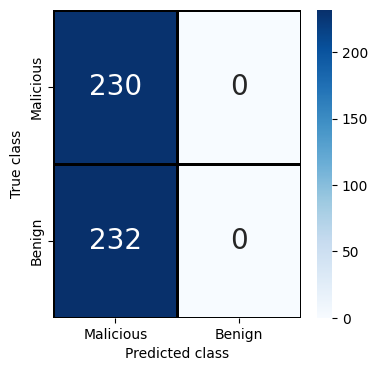

In [22]:
import pickle
from sklearn.svm import OneClassSVM
from sklearn import metrics
from utils.visualization import plot_cf_matrix

nu = 0.5421052631578948
gamma = 0.0036848421052631582

model = OneClassSVM(nu=nu, kernel="rbf", gamma = gamma)
model.fit(df_train_svm.values)

with open(f'../saved_models/pca_ocsvm/ocsvm_nu_{nu}_gamma_{gamma}.pkl', 'wb') as file:
    pickle.dump(model, file)

# change label to match oc svm
label_ocsvm = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
spoofed_for_test['label_ocsvm'] = label_ocsvm
 
y_pred = model.predict(spoofed_for_test[['pca-one', 'pca-two', 'pca-three']].values)
y_true = spoofed_for_test.label_ocsvm

print(metrics.classification_report(y_true, y_pred, digits=5))
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
plot_cf_matrix(conf_matrix)

## Local Outlier Factor (LOF)

### lof data preparation

In [9]:
df_train_lof = df_train[['pca-one', 'pca-two', 'pca-three']]
df_train_lof

,pca-one,pca-two,pca-three
0,0.706322,0.564971,0.519280
1,0.706343,0.565724,0.517880
2,0.705644,0.565487,0.517052
3,0.703305,0.567606,0.511620
4,0.702291,0.567615,0.509598
...,...,...,...
3273,0.394640,0.244148,0.619074
3274,0.696949,0.607315,0.498106
3275,0.684969,0.587783,0.511861
3276,0.693821,0.583360,0.528489


In [10]:
label_lof = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
spoofed_for_test['label_lof'] = label_lof
spoofed_for_test

,pca-one,pca-two,pca-three,label,label_lof
0,-1.439346,4.153807,-0.866847,0,1
1,-1.395856,4.423392,-1.049596,0,1
2,-1.970696,3.556558,-0.702043,0,1
3,-1.907315,3.772671,-0.837110,0,1
4,-1.791436,3.978190,-0.942015,0,1
...,...,...,...,...,...
457,-1.314267,3.212300,-2.362250,1,-1
458,-1.335627,3.184107,-2.359143,1,-1
459,-1.456717,3.033321,-2.332215,1,-1
460,-1.327511,3.180854,-2.377327,1,-1


### train lof

In [23]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_recall_fscore_support as score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns

from utils.visualization import plot_cf_matrix
from models.lof import optimize_LocalOutlierFactor

neighbor_opt, fscore = optimize_LocalOutlierFactor(
    df_train_lof, 
    spoofed_for_test, 
    neighbors_arange=(10,3000,100)
    )
    
print("Highest acheived macro average F1 was %f using %f neighbours" % (fscore, neighbor_opt))
print(metrics.classification_report(y_true, y_pred, digits=5))
print(conf_matrix)

Highest acheived macro average F1 was 0.332370 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49784   1.00000   0.66474       230
           1    0.00000   0.00000   0.00000       232

    accuracy                        0.49784       462
   macro avg    0.24892   0.50000   0.33237       462
weighted avg    0.24784   0.49784   0.33093       462

[[230   0]
 [232   0]]


/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



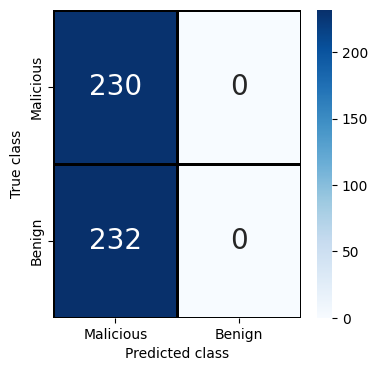

In [13]:
plot_cf_matrix(conf_matrix)

## Autoencoder

An Autoencoder Neural Network works by taking input, compressing it and trying to *reproduce the same input*. It is trained on a benign dataset using MSE. 

**Threshold**: If the MSE of the reconstructed output is over a delta threshold, 𝑇, it is classified as a novelty.
The paper did not tell us how to pick the proper threshold.

In [13]:
df_train_ae = df_train.drop(columns=['trace'])

### Autoencoder data preparation

In [14]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(df_train_ae, df_train_ae, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# turn to tensor
autoencoder_X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
autoencoder_y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
autoencoder_X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
autoencoder_y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
autoencoder_X_val_tensor = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
autoencoder_y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32)

# create TensorDataset
autoencoder_train_dataset = TensorDataset(autoencoder_X_train_tensor, autoencoder_y_train_tensor)
autoencoder_test_dataset = TensorDataset(autoencoder_X_test_tensor, autoencoder_y_test_tensor)
autoencoder_val_dataset = TensorDataset(autoencoder_X_val_tensor, autoencoder_y_val_tensor)

### Autoencoder Training

Monitor on wandb 

Epoch 1/100


100%|██████████| 72/72 [00:00<00:00, 1986.75it/s]


Train Loss: 2.190361613407731


100%|██████████| 16/16 [00:00<00:00, 3821.47it/s]


Val Loss: 0.021982230246067047
Epoch 2/100


100%|██████████| 72/72 [00:00<00:00, 1935.73it/s]


Train Loss: 1.4733751015737653


100%|██████████| 16/16 [00:00<00:00, 3619.88it/s]


Val Loss: 0.019615283235907555
Epoch 3/100


100%|██████████| 72/72 [00:00<00:00, 1729.79it/s]


Train Loss: 1.3231885870918632


100%|██████████| 16/16 [00:00<00:00, 3767.62it/s]


Val Loss: 0.019651608541607857
Epoch 4/100


100%|██████████| 72/72 [00:00<00:00, 2043.81it/s]


Train Loss: 1.1794181214645505


100%|██████████| 16/16 [00:00<00:00, 3236.35it/s]


Val Loss: 0.019691498950123787
Epoch 5/100


100%|██████████| 72/72 [00:00<00:00, 640.13it/s]


Train Loss: 1.0100235072895885


100%|██████████| 16/16 [00:00<00:00, 4078.57it/s]


Val Loss: 0.010694567114114761
Epoch 6/100


100%|██████████| 72/72 [00:00<00:00, 1857.44it/s]


Train Loss: 0.8237913073971868


100%|██████████| 16/16 [00:00<00:00, 4176.29it/s]


Val Loss: 0.015428423881530762
Epoch 7/100


100%|██████████| 72/72 [00:00<00:00, 2034.81it/s]


Train Loss: 0.6491556530818343


100%|██████████| 16/16 [00:00<00:00, 4484.09it/s]


Val Loss: 0.00914692971855402
Epoch 8/100


100%|██████████| 72/72 [00:00<00:00, 2037.80it/s]


Train Loss: 0.5232683378271759


100%|██████████| 16/16 [00:00<00:00, 3876.88it/s]


Val Loss: 0.0038172537460923195
Epoch 9/100


100%|██████████| 72/72 [00:00<00:00, 1833.98it/s]


Train Loss: 0.4315299990121275


100%|██████████| 16/16 [00:00<00:00, 3932.31it/s]


Val Loss: 0.006523485761135817
Epoch 10/100


100%|██████████| 72/72 [00:00<00:00, 1764.41it/s]


Train Loss: 0.39554846403189003


100%|██████████| 16/16 [00:00<00:00, 3216.18it/s]


Val Loss: 0.006566931959241629
Epoch 11/100


100%|██████████| 72/72 [00:00<00:00, 1741.65it/s]


Train Loss: 0.3753857100382447


100%|██████████| 16/16 [00:00<00:00, 4227.33it/s]


Val Loss: 0.004480685573071241
Epoch 12/100


100%|██████████| 72/72 [00:00<00:00, 2056.31it/s]


Train Loss: 0.34867961262352765


100%|██████████| 16/16 [00:00<00:00, 4127.74it/s]


Val Loss: 0.0029647592455148697
Epoch 13/100


100%|██████████| 72/72 [00:00<00:00, 694.77it/s]


Train Loss: 0.31163422390818596


100%|██████████| 16/16 [00:00<00:00, 4029.11it/s]


Val Loss: 0.0028665040154010057
Epoch 14/100


100%|██████████| 72/72 [00:00<00:00, 1562.64it/s]


Train Loss: 0.27904426131863147


100%|██████████| 16/16 [00:00<00:00, 4460.54it/s]


Val Loss: 0.005336069501936436
Epoch 15/100


100%|██████████| 72/72 [00:00<00:00, 1888.49it/s]


Train Loss: 0.2497647813288495


100%|██████████| 16/16 [00:00<00:00, 4687.68it/s]


Val Loss: 0.0035061256494373083
Epoch 16/100


100%|██████████| 72/72 [00:00<00:00, 2045.45it/s]


Train Loss: 0.2278858725912869


100%|██████████| 16/16 [00:00<00:00, 4154.83it/s]


Val Loss: 0.004730386659502983
Epoch 17/100


100%|██████████| 72/72 [00:00<00:00, 1728.81it/s]


Train Loss: 0.21314788050949574


100%|██████████| 16/16 [00:00<00:00, 4188.28it/s]


Val Loss: 0.002718854695558548
Epoch 18/100


100%|██████████| 72/72 [00:00<00:00, 1850.76it/s]


Train Loss: 0.2018802238162607


100%|██████████| 16/16 [00:00<00:00, 4237.47it/s]


Val Loss: 0.0016736849211156368
Epoch 19/100


100%|██████████| 72/72 [00:00<00:00, 1789.09it/s]


Train Loss: 0.19349640992004424


100%|██████████| 16/16 [00:00<00:00, 4422.04it/s]


Val Loss: 0.0012141005136072636
Epoch 20/100


100%|██████████| 72/72 [00:00<00:00, 1941.16it/s]


Train Loss: 0.1894657185766846


100%|██████████| 16/16 [00:00<00:00, 3929.09it/s]


Val Loss: 0.001176017103716731
Epoch 21/100


100%|██████████| 72/72 [00:00<00:00, 630.85it/s]


Train Loss: 0.18415491457562894


100%|██████████| 16/16 [00:00<00:00, 3762.13it/s]


Val Loss: 0.002611855510622263
Epoch 22/100


100%|██████████| 72/72 [00:00<00:00, 1358.75it/s]


Train Loss: 0.18146268464624882


100%|██████████| 16/16 [00:00<00:00, 4326.81it/s]


Val Loss: 0.0015340505633503199
Epoch 23/100


100%|██████████| 72/72 [00:00<00:00, 1588.08it/s]


Train Loss: 0.1780302618863061


100%|██████████| 16/16 [00:00<00:00, 3921.51it/s]


Val Loss: 0.001299386378377676
Epoch 24/100


100%|██████████| 72/72 [00:00<00:00, 1990.77it/s]


Train Loss: 0.17521917750127614


100%|██████████| 16/16 [00:00<00:00, 3986.98it/s]


Val Loss: 0.0014322581700980663
Epoch 25/100


100%|██████████| 72/72 [00:00<00:00, 1745.54it/s]


Train Loss: 0.17346355866175145


100%|██████████| 16/16 [00:00<00:00, 4404.05it/s]


Val Loss: 0.0013305065222084522
Epoch 26/100


100%|██████████| 72/72 [00:00<00:00, 1371.32it/s]


Train Loss: 0.17153688368853182


100%|██████████| 16/16 [00:00<00:00, 2343.02it/s]


Val Loss: 0.0018007680773735046
Epoch 27/100


100%|██████████| 72/72 [00:00<00:00, 477.51it/s]


Train Loss: 0.169791970285587


100%|██████████| 16/16 [00:00<00:00, 4326.25it/s]


Val Loss: 0.002735452726483345
Epoch 28/100


100%|██████████| 72/72 [00:00<00:00, 1443.46it/s]


Train Loss: 0.16773350012954324


100%|██████████| 16/16 [00:00<00:00, 3747.84it/s]


Val Loss: 0.0011279581813141704
Epoch 29/100


100%|██████████| 72/72 [00:00<00:00, 1960.73it/s]


Train Loss: 0.1668761036125943


100%|██████████| 16/16 [00:00<00:00, 4253.32it/s]


Val Loss: 0.00369645981118083
Epoch 30/100


100%|██████████| 72/72 [00:00<00:00, 1762.98it/s]


Train Loss: 0.16408702335320413


100%|██████████| 16/16 [00:00<00:00, 4161.02it/s]


Val Loss: 0.0018955040723085403
Epoch 31/100


100%|██████████| 72/72 [00:00<00:00, 1589.79it/s]


Train Loss: 0.1624840932781808


100%|██████████| 16/16 [00:00<00:00, 3866.61it/s]


Val Loss: 0.0027229648549109697
Epoch 32/100


100%|██████████| 72/72 [00:00<00:00, 1804.10it/s]


Train Loss: 0.1615076411399059


100%|██████████| 16/16 [00:00<00:00, 4150.21it/s]

Val Loss: 0.002408538479357958


Epoch 33/100


100%|██████████| 72/72 [00:00<00:00, 1715.80it/s]


Train Loss: 0.16132442513480783


100%|██████████| 16/16 [00:00<00:00, 3049.43it/s]


Val Loss: 0.00113211281131953
Epoch 34/100


100%|██████████| 72/72 [00:00<00:00, 1471.58it/s]


Train Loss: 0.15931840502889827


100%|██████████| 16/16 [00:00<00:00, 3602.00it/s]


Val Loss: 0.0019547392148524523
Epoch 35/100


100%|██████████| 72/72 [00:00<00:00, 622.11it/s]


Train Loss: 0.15941753354854882


100%|██████████| 16/16 [00:00<00:00, 3465.47it/s]


Val Loss: 0.0021094828844070435
Epoch 36/100


100%|██████████| 72/72 [00:00<00:00, 1539.48it/s]


Train Loss: 0.15965508396038786


100%|██████████| 16/16 [00:00<00:00, 3669.56it/s]


Val Loss: 0.0026262581814080477
Epoch 37/100


100%|██████████| 72/72 [00:00<00:00, 1742.12it/s]


Train Loss: 0.15703271119855344


100%|██████████| 16/16 [00:00<00:00, 3994.10it/s]


Val Loss: 0.0007207586895674467
Epoch 38/100


100%|██████████| 72/72 [00:00<00:00, 2018.33it/s]


Train Loss: 0.15762011567130685


100%|██████████| 16/16 [00:00<00:00, 4081.80it/s]


Val Loss: 0.0008590839570388198
Epoch 39/100


100%|██████████| 72/72 [00:00<00:00, 1659.21it/s]


Train Loss: 0.15505790431052446


100%|██████████| 16/16 [00:00<00:00, 3210.34it/s]


Val Loss: 0.0013373070396482944
Epoch 40/100


100%|██████████| 72/72 [00:00<00:00, 1750.45it/s]


Train Loss: 0.15536972181871533


100%|██████████| 16/16 [00:00<00:00, 3794.89it/s]


Val Loss: 0.0013000088511034846
Epoch 41/100


100%|██████████| 72/72 [00:00<00:00, 1238.80it/s]


Train Loss: 0.155746363918297


100%|██████████| 16/16 [00:00<00:00, 3831.51it/s]


Val Loss: 0.0013742977753281593
Epoch 42/100


100%|██████████| 72/72 [00:00<00:00, 1732.11it/s]


Train Loss: 0.1538557739695534


100%|██████████| 16/16 [00:00<00:00, 4466.78it/s]


Val Loss: 0.0017463159747421741
Epoch 43/100


100%|██████████| 72/72 [00:00<00:00, 638.75it/s]


Train Loss: 0.153484869399108


100%|██████████| 16/16 [00:00<00:00, 3654.57it/s]


Val Loss: 0.0020332576241344213
Epoch 44/100


100%|██████████| 72/72 [00:00<00:00, 1709.15it/s]


Train Loss: 0.15301682567223907


100%|██████████| 16/16 [00:00<00:00, 3777.16it/s]


Val Loss: 0.0010994607582688332
Epoch 45/100


100%|██████████| 72/72 [00:00<00:00, 1939.03it/s]


Train Loss: 0.1531712340656668


100%|██████████| 16/16 [00:00<00:00, 4244.17it/s]


Val Loss: 0.0007518535130657256
Epoch 46/100


100%|██████████| 72/72 [00:00<00:00, 1964.20it/s]


Train Loss: 0.15048905252479017


100%|██████████| 16/16 [00:00<00:00, 4433.43it/s]


Val Loss: 0.005667572841048241
Epoch 47/100


100%|██████████| 72/72 [00:00<00:00, 1812.60it/s]


Train Loss: 0.15052997937891632


100%|██████████| 16/16 [00:00<00:00, 4089.76it/s]


Val Loss: 0.0028433529660105705
Epoch 48/100


100%|██████████| 72/72 [00:00<00:00, 1922.20it/s]


Train Loss: 0.14960425184108317


100%|██████████| 16/16 [00:00<00:00, 4251.97it/s]


Val Loss: 0.0006861856090836227
Epoch 49/100


100%|██████████| 72/72 [00:00<00:00, 1832.80it/s]


Train Loss: 0.1495833769440651


100%|██████████| 16/16 [00:00<00:00, 4122.42it/s]


Val Loss: 0.0012973792618140578
Epoch 50/100


100%|██████████| 72/72 [00:00<00:00, 1830.94it/s]


Train Loss: 0.1482936631073244


100%|██████████| 16/16 [00:00<00:00, 4053.69it/s]


Val Loss: 0.0028002287726849318
Epoch 51/100


100%|██████████| 72/72 [00:00<00:00, 687.24it/s]


Train Loss: 0.14725640090182424


100%|██████████| 16/16 [00:00<00:00, 4144.06it/s]


Val Loss: 0.0013946039834991097
Epoch 52/100


100%|██████████| 72/72 [00:00<00:00, 2205.42it/s]


Train Loss: 0.14720228762598708


100%|██████████| 16/16 [00:00<00:00, 4149.18it/s]


Val Loss: 0.0015930910594761372
Epoch 53/100


100%|██████████| 72/72 [00:00<00:00, 2104.53it/s]


Train Loss: 0.1462196593056433


100%|██████████| 16/16 [00:00<00:00, 4256.56it/s]


Val Loss: 0.0009710974991321564
Epoch 54/100


100%|██████████| 72/72 [00:00<00:00, 1760.86it/s]


Train Loss: 0.14678925479529426


100%|██████████| 16/16 [00:00<00:00, 4023.07it/s]


Val Loss: 0.001900775940157473
Epoch 55/100


100%|██████████| 72/72 [00:00<00:00, 1893.63it/s]


Train Loss: 0.14581613364862278


100%|██████████| 16/16 [00:00<00:00, 4624.05it/s]


Val Loss: 0.004015064332634211
Epoch 56/100


100%|██████████| 72/72 [00:00<00:00, 2012.02it/s]


Train Loss: 0.146234396728687


100%|██████████| 16/16 [00:00<00:00, 4516.07it/s]


Val Loss: 0.0018122734036296606
Epoch 57/100


100%|██████████| 72/72 [00:00<00:00, 1863.32it/s]


Train Loss: 0.14426776254549623


100%|██████████| 16/16 [00:00<00:00, 3813.22it/s]


Val Loss: 0.0007682384457439184
Epoch 58/100


100%|██████████| 72/72 [00:00<00:00, 1799.86it/s]


Train Loss: 0.14514660014538094


100%|██████████| 16/16 [00:00<00:00, 4393.38it/s]


Val Loss: 0.003566036932170391
Epoch 59/100


100%|██████████| 72/72 [00:00<00:00, 682.73it/s]


Train Loss: 0.1427308931015432


100%|██████████| 16/16 [00:00<00:00, 4317.07it/s]


Val Loss: 0.001091803191229701
Epoch 60/100


100%|██████████| 72/72 [00:00<00:00, 1450.88it/s]


Train Loss: 0.14191363099962473


100%|██████████| 16/16 [00:00<00:00, 4106.78it/s]


Val Loss: 0.0009822506690397859
Epoch 61/100


100%|██████████| 72/72 [00:00<00:00, 1807.92it/s]


Train Loss: 0.1428151642321609


100%|██████████| 16/16 [00:00<00:00, 4052.47it/s]


Val Loss: 0.0005605590995401144
Epoch 62/100


100%|██████████| 72/72 [00:00<00:00, 2002.11it/s]


Train Loss: 0.141346265678294


100%|██████████| 16/16 [00:00<00:00, 4412.44it/s]


Val Loss: 0.0012404823210090399
Epoch 63/100


100%|██████████| 72/72 [00:00<00:00, 2042.92it/s]


Train Loss: 0.14030769077362493


100%|██████████| 16/16 [00:00<00:00, 4089.76it/s]


Val Loss: 0.0013586462009698153
Epoch 64/100


100%|██████████| 72/72 [00:00<00:00, 1857.21it/s]


Train Loss: 0.14016355836065486


100%|██████████| 16/16 [00:00<00:00, 4415.06it/s]


Val Loss: 0.001450156676582992
Epoch 65/100


100%|██████████| 72/72 [00:00<00:00, 1926.23it/s]


Train Loss: 0.14167104713851586


100%|██████████| 16/16 [00:00<00:00, 4045.63it/s]


Val Loss: 0.0010177572257816792
Epoch 66/100


100%|██████████| 72/72 [00:00<00:00, 1907.89it/s]


Train Loss: 0.13941332721151412


100%|██████████| 16/16 [00:00<00:00, 4435.78it/s]


Val Loss: 0.0020912333857268095
Epoch 67/100


100%|██████████| 72/72 [00:00<00:00, 688.73it/s]


Train Loss: 0.13857469987124205


100%|██████████| 16/16 [00:00<00:00, 3694.20it/s]


Val Loss: 0.0007688896730542183
Epoch 68/100


100%|██████████| 72/72 [00:00<00:00, 1845.92it/s]


Train Loss: 0.1379302324494347


100%|██████████| 16/16 [00:00<00:00, 4294.14it/s]


Val Loss: 0.0012529711239039898
Epoch 69/100


100%|██████████| 72/72 [00:00<00:00, 1921.02it/s]


Train Loss: 0.13741764251608402


100%|██████████| 16/16 [00:00<00:00, 4004.11it/s]


Val Loss: 0.0014473773771896958
Epoch 70/100


100%|██████████| 72/72 [00:00<00:00, 1731.75it/s]


Train Loss: 0.13747728342423216


100%|██████████| 16/16 [00:00<00:00, 3655.57it/s]


Val Loss: 0.001290078042075038
Epoch 71/100


100%|██████████| 72/72 [00:00<00:00, 1971.74it/s]


Train Loss: 0.13658546196529642


100%|██████████| 16/16 [00:00<00:00, 4694.57it/s]


Val Loss: 0.0008000859525054693
Epoch 72/100


100%|██████████| 72/72 [00:00<00:00, 1937.78it/s]


Train Loss: 0.13647367421071976


100%|██████████| 16/16 [00:00<00:00, 4284.00it/s]


Val Loss: 0.0006251317681744695
Epoch 73/100


100%|██████████| 72/72 [00:00<00:00, 1942.11it/s]


Train Loss: 0.13580042641842738


100%|██████████| 16/16 [00:00<00:00, 4718.33it/s]


Val Loss: 0.0005561311263591051
Epoch 74/100


100%|██████████| 72/72 [00:00<00:00, 1360.98it/s]


Train Loss: 0.1350621534511447


100%|██████████| 16/16 [00:00<00:00, 4461.73it/s]


Val Loss: 0.002552296966314316
Epoch 75/100


100%|██████████| 72/72 [00:00<00:00, 626.46it/s]


Train Loss: 0.13502839219290763


100%|██████████| 16/16 [00:00<00:00, 4315.96it/s]


Val Loss: 0.0009267878485843539
Epoch 76/100


100%|██████████| 72/72 [00:00<00:00, 2008.83it/s]


Train Loss: 0.13405911641893908


100%|██████████| 16/16 [00:00<00:00, 4443.41it/s]


Val Loss: 0.003080471185967326
Epoch 77/100


100%|██████████| 72/72 [00:00<00:00, 1900.97it/s]


Train Loss: 0.13399701588787138


100%|██████████| 16/16 [00:00<00:00, 4164.37it/s]


Val Loss: 0.003147537587210536
Epoch 78/100


100%|██████████| 72/72 [00:00<00:00, 1963.94it/s]


Train Loss: 0.13320384419057518


100%|██████████| 16/16 [00:00<00:00, 4381.05it/s]


Val Loss: 0.002054294804111123
Epoch 79/100


100%|██████████| 72/72 [00:00<00:00, 2002.68it/s]


Train Loss: 0.1326297102496028


100%|██████████| 16/16 [00:00<00:00, 4683.76it/s]


Val Loss: 0.007156955543905497
Epoch 80/100


100%|██████████| 72/72 [00:00<00:00, 2020.68it/s]


Train Loss: 0.1319646491901949


100%|██████████| 16/16 [00:00<00:00, 4436.95it/s]


Val Loss: 0.0015667747939005494
Epoch 81/100


100%|██████████| 72/72 [00:00<00:00, 1736.57it/s]


Train Loss: 0.13181677379179746


100%|██████████| 16/16 [00:00<00:00, 3901.45it/s]


Val Loss: 0.010653438977897167
Epoch 82/100


100%|██████████| 72/72 [00:00<00:00, 1918.57it/s]


Train Loss: 0.13176114702946506


100%|██████████| 16/16 [00:00<00:00, 4390.79it/s]


Val Loss: 0.0009309119777753949
Epoch 83/100


100%|██████████| 72/72 [00:00<00:00, 660.41it/s]


Train Loss: 0.13100380671676248


100%|██████████| 16/16 [00:00<00:00, 3557.32it/s]


Val Loss: 0.0006202607764862478
Epoch 84/100


100%|██████████| 72/72 [00:00<00:00, 1749.02it/s]


Train Loss: 0.13021986035164446


100%|██████████| 16/16 [00:00<00:00, 3936.00it/s]


Val Loss: 0.0006710460875183344
Epoch 85/100


100%|██████████| 72/72 [00:00<00:00, 1650.46it/s]


Train Loss: 0.1306998231448233


100%|██████████| 16/16 [00:00<00:00, 4467.97it/s]


Val Loss: 0.0009735965286381543
Epoch 86/100


100%|██████████| 72/72 [00:00<00:00, 1988.14it/s]


Train Loss: 0.13011169288074598


100%|██████████| 16/16 [00:00<00:00, 4282.91it/s]


Val Loss: 0.0016033946303650737
Epoch 87/100


100%|██████████| 72/72 [00:00<00:00, 1903.65it/s]


Train Loss: 0.12996227719122544


100%|██████████| 16/16 [00:00<00:00, 3713.01it/s]


Val Loss: 0.0030415127985179424
Epoch 88/100


100%|██████████| 72/72 [00:00<00:00, 1606.11it/s]


Train Loss: 0.12868311372585595


100%|██████████| 16/16 [00:00<00:00, 4410.12it/s]


Val Loss: 0.00044949151924811304
Epoch 89/100


100%|██████████| 72/72 [00:00<00:00, 1759.70it/s]


Train Loss: 0.1281101463828236


100%|██████████| 16/16 [00:00<00:00, 3695.02it/s]


Val Loss: 0.0008383959648199379
Epoch 90/100


100%|██████████| 72/72 [00:00<00:00, 702.66it/s]


Train Loss: 0.12786897865589708


100%|██████████| 16/16 [00:00<00:00, 4296.34it/s]


Val Loss: 0.0007063154480420053
Epoch 91/100


100%|██████████| 72/72 [00:00<00:00, 1901.78it/s]


Train Loss: 0.12908340798458084


100%|██████████| 16/16 [00:00<00:00, 4182.02it/s]


Val Loss: 0.0006312146433629096
Epoch 92/100


100%|██████████| 72/72 [00:00<00:00, 1844.49it/s]


Train Loss: 0.12739205383695662


100%|██████████| 16/16 [00:00<00:00, 4186.19it/s]


Val Loss: 0.0018757161451503634
Epoch 93/100


100%|██████████| 72/72 [00:00<00:00, 2068.54it/s]


Train Loss: 0.12758098979247734


100%|██████████| 16/16 [00:00<00:00, 4455.51it/s]


Val Loss: 0.0019462574273347855
Epoch 94/100


100%|██████████| 72/72 [00:00<00:00, 1906.43it/s]


Train Loss: 0.12724584707757458


100%|██████████| 16/16 [00:00<00:00, 4042.46it/s]


Val Loss: 0.0011458277003839612
Epoch 95/100


100%|██████████| 72/72 [00:00<00:00, 1771.38it/s]


Train Loss: 0.12641934829298407


100%|██████████| 16/16 [00:00<00:00, 4391.08it/s]


Val Loss: 0.0015067377826198936
Epoch 96/100


100%|██████████| 72/72 [00:00<00:00, 1889.27it/s]


Train Loss: 0.12579219846520573


100%|██████████| 16/16 [00:00<00:00, 4062.03it/s]


Val Loss: 0.0014630492078140378
Epoch 97/100


100%|██████████| 72/72 [00:00<00:00, 1291.32it/s]


Train Loss: 0.12734379194444045


100%|██████████| 16/16 [00:00<00:00, 4031.29it/s]


Val Loss: 0.0027511424850672483
Epoch 98/100


100%|██████████| 72/72 [00:00<00:00, 686.10it/s]


Train Loss: 0.1257479411433451


100%|██████████| 16/16 [00:00<00:00, 4183.06it/s]


Val Loss: 0.0022810178343206644
Epoch 99/100


100%|██████████| 72/72 [00:00<00:00, 1477.01it/s]


Train Loss: 0.12421639123931527


100%|██████████| 16/16 [00:00<00:00, 4296.34it/s]


Val Loss: 0.001976481406018138
Epoch 100/100


100%|██████████| 72/72 [00:00<00:00, 1873.89it/s]


Train Loss: 0.12529246899066493


100%|██████████| 16/16 [00:00<00:00, 3853.73it/s]


Val Loss: 0.0022069509141147137


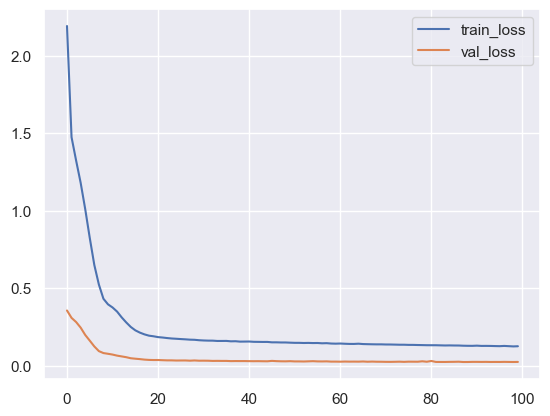

Finished Training


loss,█▅▄▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00418
val_loss,0.02416


In [16]:
df_train, pca_train

from models.autoencoder import Autoencoder
from utils.trainer import Trainer
from sklearn.model_selection import train_test_split

FIRST_LAYER_SIZE = 25
HIDDEN_SIZE = 3
LAST_LAYER_SIZE = 25
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 100

# creare Dataloader
autoencoder_train_dataloader = DataLoader(autoencoder_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
autoencoder_test_dataloader = DataLoader(autoencoder_test_dataset, batch_size=BATCH_SIZE, shuffle=True)
autoencoder_val_dataloader = DataLoader(autoencoder_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

autoencoder_model = Autoencoder(input_size=N_COMPONENTS,
                                first_layer_size= FIRST_LAYER_SIZE,
                                hidden_size= HIDDEN_SIZE,
                                last_layer_size= LAST_LAYER_SIZE,
                                output_size= N_COMPONENTS,
                                )

autoencoder_criterion = torch.nn.MSELoss()
#adam optimizer
autoencoder_optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)

autoencoder_trainer = Trainer(model=autoencoder_model, 
                              train_loader=autoencoder_train_dataloader,
                              val_loader=autoencoder_val_dataloader,
                              criterion=autoencoder_criterion,
                              optimizer=autoencoder_optimizer,
                              if_wandb=True,
                              wandb_project_name="autoencoder",)

autoencoder_trainer.train(epochs=EPOCHS)

In [21]:
#save model
autoencoder_trainer.save_model(path = f'../saved_models/pca_autoencoder/autoencoder.pth')

In [23]:
op = torch.optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)

### Threshold